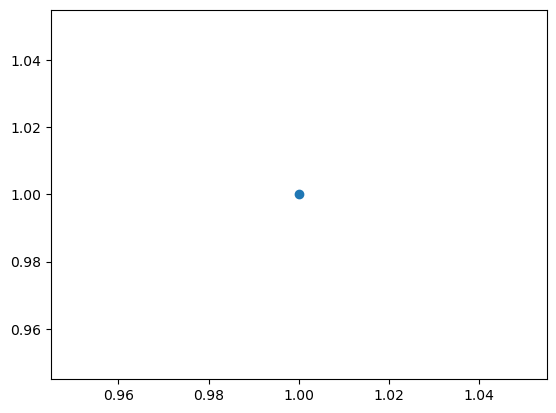

In [1]:
import matplotlib.pyplot as plt
plt.scatter(1,1)

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np

In [37]:
main_dir = 'Small_dataset'
train_dir = 'Training/'
test_dir = 'Test/'
class_names = os.listdir(os.path.join(main_dir, train_dir))

In [68]:
class BB_Regressor_fc_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(1024*3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 100)
        self.fc6 = nn.Linear(100, 2)
        
    def forward(self, X):

        X = X.view(-1, 1024*3)
        
        X = self.fc1(X)
        X = F.sigmoid(X)
        X = X * 0.01

        X = self.fc5(X)
        X = F.sigmoid(X)
        X = X * 0.01
        
        X = self.fc6(X)
        X = F.sigmoid(X)
        
        return X


In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
regressor_model = BB_Regressor_fc_model().to(device)
NAME = 'RCNN_F1'
epoche = 0
test_acc = None
best = 0
BEST_NET = None

In [70]:
def change_dl_params(train_data, batch_size):
    center_shift = np.random.random((1,2))
    zoom = np.random.random() * 0.6 + 0.5 #scale   0.5 => 1.1
    transform=transforms.Compose([transforms.RandomAffine(degrees=(0, 0), translate=(0, 0), scale=(zoom, zoom), fill=255),
                                                               transforms.Pad(list(map(int,[100*center_shift[0][0],
                                                                                            0,
                                                                                            100*(1-center_shift[0][0]),
                                                                                            0])),fill=255),
                                                               transforms.CenterCrop((100,100)),
                                                               transforms.Pad(list(map(int,[0,
                                                                                            100*(1-center_shift[0][1]),
                                                                                            0,
                                                                                            100*center_shift[0][1]])),fill=255),
                                                               transforms.CenterCrop((100,100)),
                                                               transforms.Resize((32, 32)),
                                                               transforms.ToTensor()
                                                              ])
    train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
                                   
    return train_loader, [ center_shift[0][0]-0.5, center_shift[0][1] - 0.5] 

In [71]:
epochs = 10000
learning_rate = 0.000001

criterion = nn.CrossEntropyLoss()

optimizer_regressor = torch.optim.Adam(regressor_model.parameters(), 0.1*learning_rate, weight_decay=0.0001)

train_transforms = transforms.Compose([transforms.Resize((32, 32)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomAffine(degrees=(-5, 5), translate=(0.2, 0.2), scale=(0.7, 1.1), fill=255),
                                       transforms.ToTensor()
                                      ])
test_transforms = train_transforms

train_data = datasets.ImageFolder(os.path.join(main_dir, train_dir), transform=train_transforms)
test_data = datasets.ImageFolder(os.path.join(main_dir, test_dir), transform=test_transforms)

BATCH_SIZE = len(test_data)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [72]:
torch.autograd.set_detect_anomaly(True)
loss_log = []
for cur in range(epochs):
    epoche += 1
    
    obj_number = 0
    correct_obj = 0

    new_train_loader, BB_adviсe = change_dl_params(train_data, BATCH_SIZE)
    bounding_shift = torch.tensor([BB_adviсe for i in range(BATCH_SIZE)]).to(device)

    a = 0
    for x, y in new_train_loader:
        a += 1    
        inputs, labels = x.to(device), y.to(device)

        optimizer_regressor.zero_grad()
        
        output2 = regressor_model(inputs)

        loss_regressor = (criterion(output2, bounding_shift) if len(output2) == len(bounding_shift) 
                          else criterion(output2, bounding_shift[:len(output2)]))
        


        loss_regressor.backward(retain_graph=True)  
        optimizer_regressor.step()

        loss_log.append(loss_regressor)
 
    
        print(f"Эпоха: {epoche} , проход {round(100*obj_number/len(train_data),2)}% , ошибка регрессии = {loss_regressor}       ",
              sep='', end='\r')
        if a == 1:
            a =0
            break


KeyboardInterrupt: 

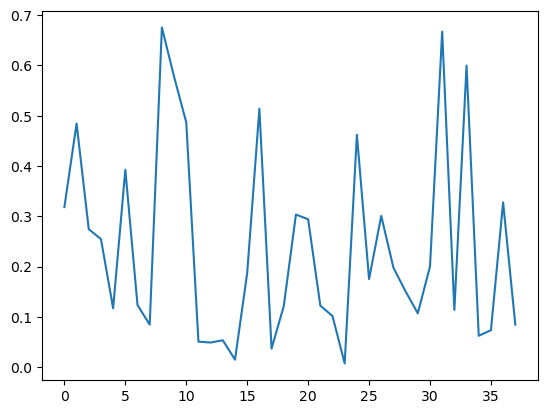

In [67]:
ll = [float(x) for x in loss_log]
plt.plot(range(len(ll)), np.abs(ll))

In [ ]:
inputs, _ = x.to(device), y.to(device)
output = model(inputs)
print(output.shape[1])

Со смещением (вправо, вверх):  [[0.94792003 0.79204559]] и зумом 1.0585699150734262


Модель дает прогноз:

Со смещением (вправо, вверх) и зумом:  [0.6087531447410583, 0.35007670521736145]


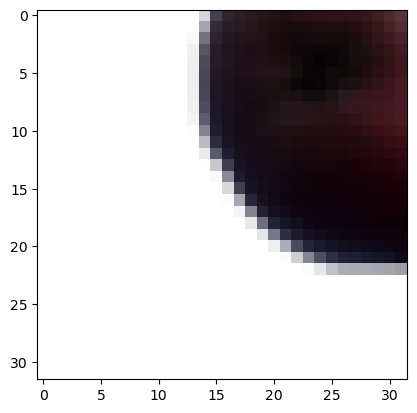

In [35]:
center_shift = np.random.random((1,2))
zoom = np.random.random() * 0.6 + 0.5
test_data = datasets.ImageFolder(os.path.join(main_dir, test_dir),
                                 transform=transforms.Compose([transforms.RandomAffine(degrees=(0, 0), translate=(0, 0), scale=(zoom, zoom), fill=255),
                                                               transforms.Pad(list(map(int,[100*center_shift[0][0],
                                                                                            0,
                                                                                            100*(1-center_shift[0][0]),
                                                                                            0])),fill=255),
                                                               transforms.CenterCrop((100,100)),
                                                               transforms.Pad(list(map(int,[0,
                                                                                            100*(1-center_shift[0][1]),
                                                                                            0,
                                                                                            100*center_shift[0][1]])),fill=255),
                                                               transforms.CenterCrop((100,100)),
                                                               transforms.Resize((32, 32)),
                                      
                                                               #transforms.RandomHorizontalFlip(),
                                                               #transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.5), scale=(0.5, 1.1), fill=255),
                                                               transforms.ToTensor()
                                                              ]))
number = np.random.randint(len(test_data))

image, label = test_data[int(number)]
image_np = np.array(image)
image_np = image_np.transpose((1, 2, 0))
plt.imshow(image_np)


window = regressor_model(image.unsqueeze(0).to(device))



print("Со смещением (вправо, вверх): ", center_shift,"и зумом", zoom)
print("\n\nМодель дает прогноз:\n")
print("Со смещением (вправо, вверх) и зумом: ", list([float(z) for z in window[0]]))